In [17]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           


  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=5c29a495d0bd2c967d067d83f4d8e5c6ddb13e3cb881e7b3c64c88aba0bfa7a2
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 99% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [24]:
#!rm -rf /kaggle/working/*

In [46]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
import random
from torch.utils.data import random_split, DataLoader
import torch
from collections import Counter
import numpy as np
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import pandas as pd

In [14]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [12]:
import torch
torch.cuda.empty_cache()


In [47]:
dataset_path = '/kaggle/input/cub2002011/CUB_200_2011'  # Set to the directory where your dataset is stored

# Load metadata files
class_labels_df = pd.read_csv(os.path.join(dataset_path, 'image_class_labels.txt'), sep=' ', header=None, names=['img_id', 'class_id'])
train_test_split_df = pd.read_csv(os.path.join(dataset_path, 'train_test_split.txt'), sep=' ', header=None, names=['img_id', 'is_train'])
images_df = pd.read_csv(os.path.join(dataset_path, 'images.txt'), sep=' ', header=None, names=['img_id', 'image_path'])
classes_df = pd.read_csv(os.path.join(dataset_path, 'classes.txt'), sep=' ', header=None, names=['class_id', 'class_name'])

# Merge dataframes to get a single dataframe with all necessary information
data_df = images_df.merge(class_labels_df, on='img_id').merge(train_test_split_df, on='img_id')


In [63]:
class BirdSpeciesDataset(Dataset):
    def __init__(self, dataframe, dataset_path, transform=None, train=True):
        # Filter for train or test split
        self.dataframe = dataframe[dataframe['is_train'] == (1 if train else 0)]
        self.dataset_path = dataset_path
        self.transform = transform
        
        # Load class names from classes.txt
        classes_file = os.path.join(dataset_path, 'classes.txt')
        with open(classes_file, 'r') as f:
            self.classes = [line.strip().split(' ', 1)[1] for line in f.readlines()]  # Store class names in a list


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and class label for the given index
        img_path = os.path.join(self.dataset_path, 'images', self.dataframe.iloc[idx]['image_path'])
        label = self.dataframe.iloc[idx]['class_id'] - 1  # Convert to 0-indexed label

        # Load image
        image = Image.open(img_path).convert('RGB')

         # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label


In [64]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Increased rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Validation and Test Transformations (no augmentations here, just resizing and normalization)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [65]:
# Create train and test datasets
train_dataset = BirdSpeciesDataset(data_df, dataset_path=dataset_path, transform=train_transform, train=True)
test_dataset = BirdSpeciesDataset(data_df, dataset_path=dataset_path, transform=test_transform, train=False)


In [66]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [67]:
# Print the number of samples in the training and testing datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")


Training set size: 5994
Testing set size: 5794


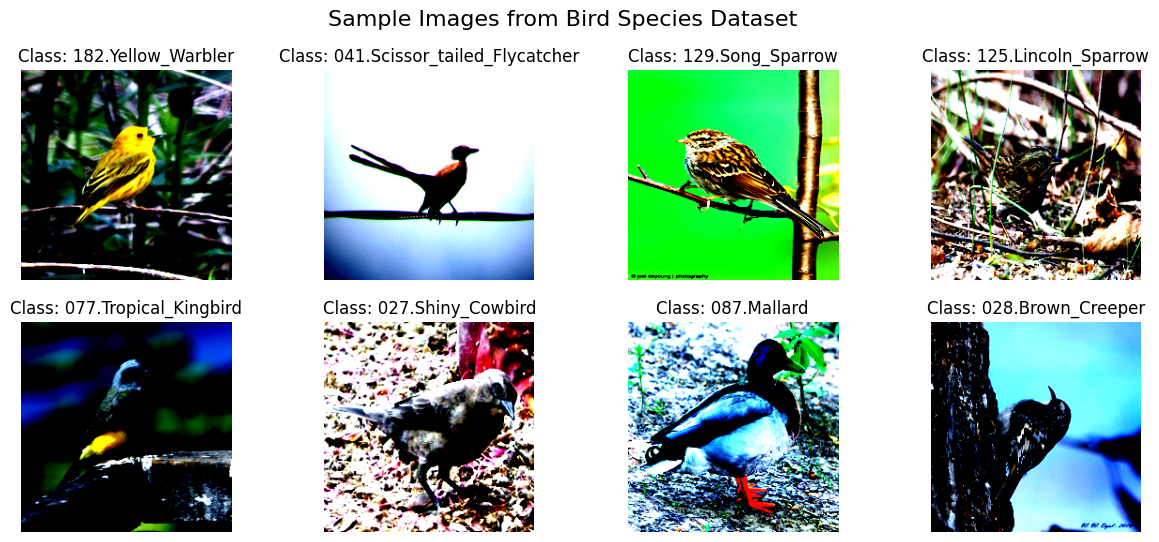

In [69]:
import torch
import matplotlib.pyplot as plt
import random
from torchvision.transforms import functional as F

# Define a function to visualize a batch of images with labels
def visualize_data(dataset, num_images=8):
    fig, axes = plt.subplots(2, num_images // 2, figsize=(15, 6))
    fig.suptitle("Sample Images from Bird Species Dataset", fontsize=16)

    for i in range(num_images):
        # Randomly select an image
        index = random.randint(0, len(dataset) - 1)
        image, label = dataset[index]
        
        # Convert tensor to numpy array for displaying
        # If the image is a tensor, use the following:
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC

        # Display the image with label
        ax = axes[i // (num_images // 2), i % (num_images // 2)]
        ax.imshow(image)
        ax.set_title(f"Class: {dataset.classes[label]}")
        ax.axis("off")

    plt.show()

# Visualize the data
visualize_data(test_dataset)


In [55]:
from collections import Counter
import torch

# Function to count images per class in a dataset
def count_images_per_class(dataset):
    class_counts = Counter()  # Initialize counter to count images per class
    for _, label in dataset:
        class_counts[label] += 1  # Increment count for the class label
    return class_counts

# Count images per class in the training dataset
train_class_counts = count_images_per_class(train_dataset)
# Count images per class in the testing dataset
test_class_counts = count_images_per_class(test_dataset)

# Print class counts for train dataset
print("Training Dataset Class Distribution:")
for class_id, count in train_class_counts.items():
    print(f"Class {class_id}: {count} images")

# Print class counts for test dataset
print("\nTesting Dataset Class Distribution:")
for class_id, count in test_class_counts.items():
    print(f"Class {class_id}: {count} images")


Training Dataset Class Distribution:
Class 0: 30 images
Class 1: 30 images
Class 2: 30 images
Class 3: 30 images
Class 4: 30 images
Class 5: 30 images
Class 6: 30 images
Class 7: 30 images
Class 8: 30 images
Class 9: 30 images
Class 10: 30 images
Class 11: 30 images
Class 12: 30 images
Class 13: 30 images
Class 14: 30 images
Class 15: 30 images
Class 16: 30 images
Class 17: 30 images
Class 18: 30 images
Class 19: 30 images
Class 20: 30 images
Class 21: 30 images
Class 22: 30 images
Class 23: 30 images
Class 24: 30 images
Class 25: 30 images
Class 26: 30 images
Class 27: 30 images
Class 28: 30 images
Class 29: 30 images
Class 30: 30 images
Class 31: 30 images
Class 32: 30 images
Class 33: 30 images
Class 34: 30 images
Class 35: 30 images
Class 36: 30 images
Class 37: 30 images
Class 38: 30 images
Class 39: 30 images
Class 40: 30 images
Class 41: 30 images
Class 42: 30 images
Class 43: 30 images
Class 44: 30 images
Class 45: 30 images
Class 46: 30 images
Class 47: 30 images
Class 48: 30 

In [83]:
# Load the pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier (fully connected layer)
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last convolutional block (denseblock4)
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

# Optionally unfreeze earlier layers if needed (e.g., denseblock3)
# You can experiment with unfreezing more layers based on your requirement
for param in model.features.denseblock3.parameters():
    param.requires_grad = True

# Modify the classifier for your specific task (e.g., 200 classes)
num_classes = 200  # Update this based on your dataset
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Add dropout to reduce overfitting
    nn.Linear(model.classifier.in_features, num_classes)  # Adjust output layer for 200 classes
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)



In [114]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])


In [115]:
# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)

# Early stopping parameters
patience = 5  # Stop if no improvement in validation loss after 5 epochs
min_delta = 0.001  # Minimum improvement in loss to qualify as an improvement
best_val_loss = np.inf  # Initialize with a large value
epochs_no_improve = 0  # Counter for epochs with no improvement


In [116]:
# Train and validation functions
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * correct / total
    return epoch_loss, accuracy


In [87]:
# Training loop with early stopping
num_epochs = 100
train_losses, valid_losses = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%")

    # Early stopping condition
    if valid_loss < best_val_loss - min_delta:
        best_val_loss = valid_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), "model_densenet121.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

    # Learning rate scheduler step
    scheduler.step(valid_loss)

    # Save losses for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch 1/100
Train Loss: 4.5840, Train Accuracy: 9.54%
Valid Loss: 2.8708, Valid Accuracy: 35.11%
Epoch 2/100
Train Loss: 2.9203, Train Accuracy: 32.00%
Valid Loss: 1.8140, Valid Accuracy: 54.63%
Epoch 3/100
Train Loss: 2.2909, Train Accuracy: 44.03%
Valid Loss: 1.4762, Valid Accuracy: 59.89%
Epoch 4/100
Train Loss: 1.9822, Train Accuracy: 50.48%
Valid Loss: 1.2833, Valid Accuracy: 64.22%
Epoch 5/100
Train Loss: 1.7523, Train Accuracy: 55.56%
Valid Loss: 1.1683, Valid Accuracy: 67.45%
Epoch 6/100
Train Loss: 1.6140, Train Accuracy: 58.51%
Valid Loss: 1.1701, Valid Accuracy: 66.19%
Epoch 7/100
Train Loss: 1.4916, Train Accuracy: 61.34%
Valid Loss: 1.0883, Valid Accuracy: 69.07%
Epoch 8/100
Train Loss: 1.4636, Train Accuracy: 62.61%
Valid Loss: 1.0720, Valid Accuracy: 69.26%
Epoch 9/100
Train Loss: 1.3496, Train Accuracy: 64.55%
Valid Loss: 1.0358, Valid Accuracy: 70.23%
Epoch 10/100
Train Loss: 1.2815, Train Accuracy: 66.60%
Valid Loss: 1.0673, Valid Accuracy: 70.54%
Epoch 11/100
Train L

In [88]:
# Load best model state from previous training
model.load_state_dict(torch.load("model_densenet121.pth"))


/tmp/ipykernel_30/267009395.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_densenet121.pth"))


<All keys matched successfully>

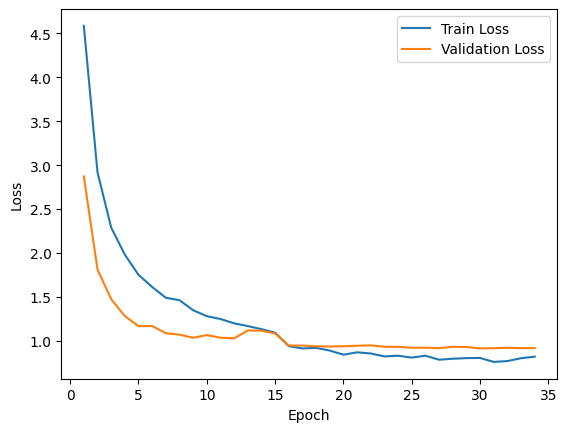

In [89]:
# Plot training and validation losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [90]:
# Assuming 'classes.txt' has two columns: 'id' and 'type'
classes_path = '/kaggle/input/cub2002011/CUB_200_2011/classes.txt'

# Load class names into a dictionary or list
class_names = {}
with open(classes_path, 'r') as file:
    for line in file:
        class_id, class_name = line.strip().split()  # Assuming space-separated values
        class_names[int(class_id)] = class_name  # Use class_id as int and map to name


In [110]:
def predict_bird(image_path):
    # Load the trained model
    model.load_state_dict(torch.load('model_densenet121.pth'))
    model.eval()  # Set the model to evaluation mode

    # Load the image and apply the transformations
    image = Image.open(image_path)
    image = test_transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the device (GPU or CPU)
    image = image.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        bird_class = predicted.item()

    # Get the corresponding bird name
    bird_name = class_names[bird_class+1]
    return bird_name

# Test prediction
image_path = '/kaggle/input/cub2002011/CUB_200_2011/images/006.Least_Auklet/Least_Auklet_0005_795119.jpg'
predicted_bird = predict_bird(image_path)
print(f"Predicted bird: {predicted_bird}")


Predicted bird: 006.Least_Auklet


/tmp/ipykernel_30/517226165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_densenet121.pth'))


In [112]:
# Load the pre-trained DenseNet model
model_1 = models.densenet121(pretrained=True)

# Freeze all layers initially
for param in model_1.parameters():
    param.requires_grad = False

# Unfreeze the classifier (fully connected layer)
for param in model_1.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last convolutional block (denseblock4)
for param in model_1.features.denseblock4.parameters():
    param.requires_grad = True

# Optionally unfreeze earlier layers if needed (e.g., denseblock3)
# You can experiment with unfreezing more layers based on your requirement
for param in model_1.features.denseblock3.parameters():
    param.requires_grad = True

for param in model_1.features.denseblock2.parameters():
    param.requires_grad = True

# Modify the classifier for your specific task (e.g., 200 classes)
num_classes = 200  # Update this based on your dataset
model_1.classifier = nn.Sequential(
    nn.Dropout(0.4),  # Add dropout to reduce overfitting
    nn.Linear(model_1.classifier.in_features, num_classes)  # Adjust output layer for 200 classes
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model_1 = model_1.to(device)



In [117]:
# Training loop with early stopping
num_epochs = 100
train_losses, valid_losses = [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_1, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(model_1, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%")

    # Early stopping condition
    if valid_loss < best_val_loss - min_delta:
        best_val_loss = valid_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model_1.state_dict(), "model_1_densenet121.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

    # Learning rate scheduler step
    scheduler.step(valid_loss)

    # Save losses for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

Epoch 1/100
Train Loss: 5.4751, Train Accuracy: 0.45%
Valid Loss: 5.4198, Valid Accuracy: 0.41%
Epoch 2/100
Train Loss: 5.4707, Train Accuracy: 0.45%
Valid Loss: 5.4200, Valid Accuracy: 0.40%
Epoch 3/100
Train Loss: 5.4682, Train Accuracy: 0.55%
Valid Loss: 5.4192, Valid Accuracy: 0.48%
Epoch 4/100
Train Loss: 5.4785, Train Accuracy: 0.50%
Valid Loss: 5.4219, Valid Accuracy: 0.41%


KeyboardInterrupt: 